In [87]:
# Version 2 de test_jupyter
# Pour différencier des séquences orfs (orf ou gène) de séquences random 
# Fichier de données : another_try.txt
#  -> toutes les sequences ont une longueur de 300 nucleotides de long
#  -> les sequences orfs sont ___,gene
#  -> les sequences random sont ___,noise
# ! ne contient que 446 sequences (223 de chaque)


In [88]:
# General import
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random


In [89]:
# Charger les données depuis la database
os.chdir("/Users/lalou/Desktop/DNA_Sequencing")
file = open("another_try.txt", 'r')
# file = open("data.txt", 'r')
lines = file.readlines()
file.close()

# Le fichier another_try.txt contient 446 sequences de 300 nucleotides de long dont :
#    - 226 orfs
#    - 226 non-orfs (créés avec un random.choice(['A', 'T', 'C', 'G']))
# Les lignes 'genes' sont les orfs
# et les lignes 'noise' sont les non-orfs


In [90]:
# Vecteurs contenant les donnees
l_used = len(lines)

seq = [line.strip().split(",")[0] for line in lines][0:l_used]
lab = [line.strip().split(",")[1] for line in lines][0:l_used]
labs = []
for i in lab:
    if i == "noise":
        labs.append(0)
    else:
        labs.append(1)

# Longueur de la plus longue séquence
m1 = max([len(i) for i in seq])


In [91]:
# Fonctions de transformation des donnees
def nucl_to_numb(letter):
    if letter == "A":
        return [1, 0, 0, 0]
    elif letter == "T":
        return [0, 1, 0, 0]
    elif letter == "G":
        return [0, 0, 1, 0]
    elif letter == "C":
        return [0, 0, 0, 1]
    else:
        print("aie", letter)
        return False
    
def seq_to_vec(sequence, l_max=m1):
    n = []
    for nucl in sequence:
        n.append(nucl_to_numb(nucl))
    while len(n) < m1:
        # n.append([0.25, 0.25, 0.25, 0.25])
        # n.append([0.00, 0.00, 0.00, 0.00])
        n.append([0.125, 0.125, 0.125, 0.125])
    return n

def vec_to_seq(array):
    n = ""
    for vec in array:
        if vec[0] == 1:
            n += "A"
        elif vec[1] == 1:
            n += "T"
        elif vec[2] == 1:
            n += "G"
        elif vec[3] == 1:
            n += "C"
        elif vec[0] == 0.25:
            return n
        else:
            print("aie")
    else:
        return n

In [92]:
# Randomisation : chgmt ordre des sequences
index = [i for i in range(len(seq))]
random.shuffle(index)
seq = [seq[i] for i in index]
labs = [labs[i] for i in index]


In [93]:
# Nom des classes
class_names = ['random', 'orf']


In [94]:
# Configuration des couches
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2)])

# keras.layers.Dense(128, activation='relu'),

In [95]:
#  Compilation du modèle
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Loss()


In [96]:
print(m1)

# Peu de données, apprentissage classique en une fois

#nbre = 6
#qtty = 50
#for i in range(nbre):
#    start = i*qtty
#    stop = (i+1)*qtty
#    seqs = [seq_to_vec(j) for j in seq[start:stop]]
#    array_seq = np.array(seqs)
#    array_seq.reshape(-1, qtty, 4)
#    array_lab = np.array(labs[start:stop])
##    array_lab.reshape(-1, 2, qtty)
#    
#    model.fit(array_seq, array_lab, epochs=3, batch_size=5)
#    
#    print("Avancée :", int(100*(i+1)/nbre), "%")
    
seqs = [seq_to_vec(j) for j in seq]
# Conversion en numpy Arrays
seqs_array = np.array(seqs)
seqs_array.reshape(-1,l_used,4)
labs_array = np.array(labs)

# Entrainer le modele
l_bis = int(0.8*l_used)
model.fit(seqs_array[0:l_bis], labs_array[0:l_bis], epochs=2, batch_size=10)

last_seqs = seqs_array[l_bis:]
last_labs = labs_array[l_bis:]

300
Epoch 1/2
36/36 [==============================] - 0s 1ms/step - loss: 0.6241 - accuracy: 0.6124
Epoch 2/2
36/36 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.9691


In [97]:
# Evaluer précision du modèle     
test_loss, test_acc = model.evaluate(last_seqs,  last_labs, verbose=1)
# print('\nTest accuracy:', test_acc)


3/3 [==============================] - 0s 998us/step - loss: 0.1329 - accuracy: 0.9667


In [98]:
# Prédictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(last_seqs)
print(predictions[0:3], last_labs[0:3])


[[0.11980672 0.8801933 ]
 [0.9470288  0.0529712 ]
 [0.4165035  0.5834966 ]] [1 0 1]


In [104]:
print(vec_to_seq(last_seqs[2]))

ATGTCTTATTTTGCAGATATAAACTTTAGTACTTTGAGGTCAATGATCCCGCCTTTTACACCCCAACTAGACAGCGAAACTGATGCCGGTTATTTTGATGACTTCACCAGTGAGGCTGACATGGCCAAATATGCTGATGTTTTCAAAAGACAAGACAAATTAACGGCTATGGTAGATGACTCGGCAGTATCATCAAAACTTGTTGGGTTCACTTTCCGACATAGAAATGGTAAACAGGGTTCCAGTGGCATCTTATTCAACGGACTGGAACACTCAGACCCCTTTTCAACCTTTTACTAG


In [100]:
# Voir les prédictions

results = [[vec_to_seq(last_seqs[i]), last_labs[i], predictions[i][last_labs[i]]] for i in range(len(predictions))]

false = []
true = [x if x[2] > 0.5 else false.append(x) for x in results]
while None in true:
    true.remove(None)
    
f_len = [[len(i[0]), i[1]] for i in false]
t_len = [[len(i[0]), i[1]] for i in true]

# print(false)

In [101]:
# Longueur des sequences qui ont ete incorrectement predites
lenf = [i[0] for i in f_len]
labf = [i[1] for i in f_len]
lf1, lf2 = [], []
for i in range(len(labf)):
    if labf[i] == 0:
        lf1.append(lenf[i])
    else:
        lf2.append(lenf[i])

# Graphe inutile car toutes les sequences ont exactement la meme longueur
#plt.figure("False Predictions")
#plt.plot(lf1, color='orange')
#plt.plot(lf2, color='magenta')
#plt.show()

print(len(f_len), "/", len(results), " : badly predicted sequences")
print(len(lf1), "/", len(lenf), " : gene predicted while orf (orange)")
print(len(lf2), "/", len(lenf), " : orf predicted while gene (magenta)")

3 / 90  : badly predicted sequences
2 / 3  : gene predicted while orf (orange)
1 / 3  : orf predicted while gene (magenta)


In [102]:
# Longueur des sequences qui ont ete correctement predites
lent = [i[0] for i in t_len]
labt = [i[1] for i in t_len]
lt1, lt2 = [], []
for i in range(len(labt)):
    if labt[i] == 0:
        lt1.append(lent[i]) # orfs
    else:
        lt2.append(lent[i]) # genes

# Graphe inutile car toutes les sequences ont exactement la meme longueur
#plt.figure("True Predictions")
#plt.plot(sorted(lt1, reverse=False), color='green')
#plt.plot(sorted(lt2, reverse=True), color='blue')
#plt.show()

print(len(t_len), "/", len(results), " : well predicted sequences")

print("   --> ", len(lt1), " : well predicted orf (green)")
print("   --> ", len(lt2), " : well predicted gene (blue)")

# print(len(lt1), "/", len(lent), " : well predicted orf (green)")
# print(len(lt2), "/", len(lent), " : well predicted gene (blue)")

87 / 90  : well predicted sequences
   -->  45  : well predicted orf (green)
   -->  42  : well predicted gene (blue)


<Figure size 432x288 with 0 Axes>

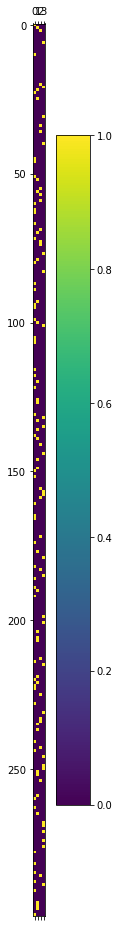

Séquences 'prédite' : 
ATGGCTCCCGATACTCTGATGCTAGTAAAGTCAGGTGCCACGAGAAATCGTATAGGTGTGAAAAAGGAGGTTAGGACCTTACTCGATAAAACTTAAAAGATCAATAAAGTGTTTATAAAGTTATATTTTCTACTGCTGATTGAGCTTCATACAGGTGCCGAATGTAATACGAGCAGTTTCCTAGCCACAATTACAGACCCGCCATTTTCTCATGACAAATATAAAGTGACGCTGGTTTTTCAAGAGCGCCCTTGGTATCTAAAATTACCCGCTACTCTAAACAACAGTACCAAATTTTAA


In [137]:
# model.summary()
x = model.trainable_variables
# print(x)


def get_bias():
    x = model.trainable_variables
    bias = []
    for i in range(len(x)):
        if i % 2 != 0:
            bias.append(x[i].numpy())
    return bias

def get_params():
    x = model.trainable_variables
    params = []
    for i in range(len(x)):
        if i % 2 == 0:
            params.append(x[i].numpy())
    return params

def get_structure():
    p = get_params()
    struct = [i for i in p[0].shape]
    for i in p[1:]:
        struct += [i.shape[1]]
    return struct

def relu_inv(y, bias = 0):
    # y = max(0, x+bias)
    x = y-bias
    if x < 0:
        # ?
        return 0
    return x

def aggregate_inv(x_out, weights):
    # x_out = [0, 1]                     de la couche suivante
    # weights = [...].shape = (4, 2)     entre les deux couches
    # return [sum([w_i[j]*x_out[j] for j in range(len(x_out))]) for w_i in weights]
    a_in = []
    for w_i in weights:
        products = [w_i[j]*x_out[j] for j in range(len(x_out))]
        a_in.append(sum(products))
    return a_in    

def normalize(vector):
    # s = max(vector)
    # s = max(max(vector), abs(min(vector)))
    s = sum(vector)/len(vector)
    return [i/s for i in vector]

def do_prediction(output = [0, 1]):
    bias = get_bias()
    params = get_params()
    struct = get_structure()
    layers = [[0]*i for i in struct]
    layers[-1] = output
    steps = 2*(len(layers)-2) +1 # 2 par couche cachee + 1 pour la derniere
    i = 0
    while i < (steps-1)/2:
        #print('i', i)
        agg = aggregate_inv(layers[-(i+1)], params[-(i+1)])
        # print('agg', len(agg))
        # print('bias', len(bias), len(bias[-(i+1)]), len(bias[-(i+2)]))
        layers[-(i+2)] = [relu_inv(agg[j], bias[-(i+2)][j]) for j in range(len(agg))]
        i += 1
    else:
        layers[0] = aggregate_inv(layers[1], params[0])
    # vecteur 4 par 4
    vec = []
    i = 0
    while i < len(layers[0]):
        vec.append(layers[0][i:i+4])
        i += 4
    else:
        return vec
    return layers[0]

def clarify(vec, hidden=-1, other=0):
    # Retourne un vecteur correspondants aux lettres
    propre = []
    for i in vec:
        propre.append([0, 0, 0, 0])
        if max(i) > hidden:
            propre[-1][i.index(max(i))] = 1
        else:
            propre[-1] = [other]*4
    return propre

def clarify2(vec):
    new = []
    for i in vec:
        m = abs(min(i))
        n = [m+j for j in i]
        m = max(n)
        n1 = [j/m for j in n]
        new.append(n1)
    return new
    
pred = do_prediction([0,1])
# for i in pred:
#     print(i)
# print(len(do_prediction()))
# plt.matshow(clarify2(pred)[0:5]+clarify2(pred)[-5:])
plt.figure()
plt.matshow(clarify(pred, 0.03, 0))
plt.colorbar()
plt.show()

print("Séquences 'prédite' :", "\n"+vec_to_seq(clarify(pred)))

In [ ]:
# Verification des predictions realisees
c = 0 #tot
s1 = 0 #non-orf
s2 = 0 #orf
for i in predictions:
    c += 1
    if i[0] > i[1]:
        s1 += 1
    elif i[0] < i[1]:
        s2 += 1
    else:
        print("Waow")
print(c, s1, s2)